[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [0.0000000e+00 7.9998666e-01 6.0337139e-03 0.0000000e+00 1.9397961e-01
  0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00]
 [0.0000000e+00 3.7554799e-43 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00]]
Greedy traversal for starting state 0
0 -> 4 -> 5

Greedy traversal for starting state 1
1 -> 5

Greedy traversal for starting state 2
2 -> 3 -> 1 -> 5

Greedy traversal for starting state 3
3 -> 1 -> 5

Greedy traversal for starting state 4
4 -> 5

Greedy traversal for starting state 5
5



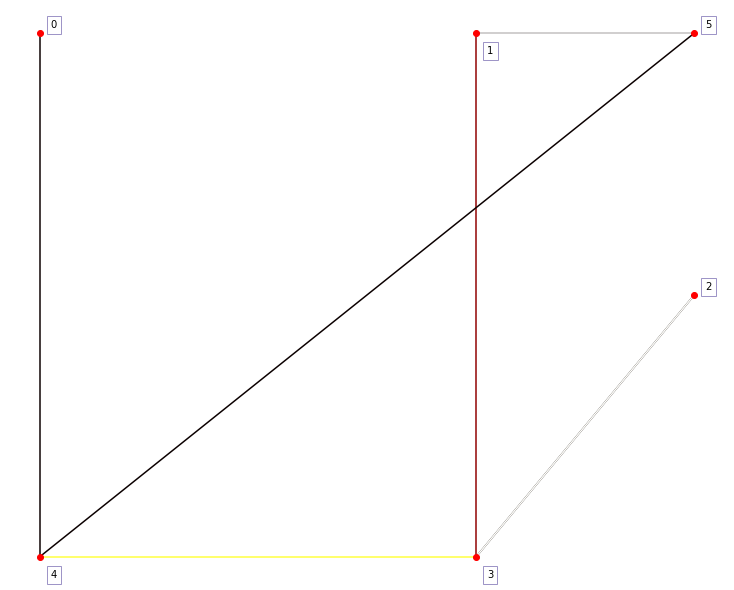

In [ ]:
# Q-learning formula from http://sarvagyavaish.github.io/FlappyBirdRL/
# Visualization based on code from Gael Varoquaux gael.varoquaux@normalesup.org
# http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html
 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
 
 
# defines the reward/connection graph
r = np.array([[-1, -1, -1, -1,  0,  -1],
              [-1, -1, -1,  0, -1, 100],
              [-1, -1, -1,  0, -1,  -1],
              [-1,  0,  0, -1,  0,  -1],
              [ 0, -1, -1,  0, -1, 100],
              [-1,  0, -1, -1,  0, 100]]).astype("float32")
q = np.zeros_like(r)
 
 
def update_q(state, next_state, action, alpha, gamma):
    rsa = r[state, action]
    qsa = q[state, action]
    new_q = qsa + alpha * (rsa + gamma * max(q[next_state, :]) - qsa)
    q[state, action] = new_q
    # renormalize row to be between 0 and 1
    rn = q[state][q[state] > 0] / np.sum(q[state][q[state] > 0])
    q[state][q[state] > 0] = rn
    return r[state, action]
 
 
def show_traverse():
    # show all the greedy traversals
    for i in range(len(q)):
        current_state = i
        traverse = "%i -> " % current_state
        n_steps = 0
        while current_state != 5 and n_steps < 20:
            next_state = np.argmax(q[current_state])
            current_state = next_state
            traverse += "%i -> " % current_state
            n_steps = n_steps + 1
        # cut off final arrow
        traverse = traverse[:-4]
        print("Greedy traversal for starting state %i" % i)
        print(traverse)
        print("")
 
 
def show_q():
    # show all the valid/used transitions
    coords = np.array([[2, 2],
                       [4, 2],
                       [5, 3],
                       [4, 4],
                       [2, 4],
                       [5, 2]])
    # invert y axis for display
    coords[:, 1] = max(coords[:, 1]) - coords[:, 1]
 
    plt.figure(1, facecolor='w', figsize=(10, 8))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')
 
    plt.scatter(coords[:, 0], coords[:, 1], c='r')
 
    start_idx, end_idx = np.where(q > 0)
    segments = [[coords[start], coords[stop]]
                for start, stop in zip(start_idx, end_idx)]
    values = np.array(q[q > 0])
    # bump up values for viz
    values = values
    lc = LineCollection(segments,
                        zorder=0, cmap=plt.cm.hot_r)
    lc.set_array(values)
    ax.add_collection(lc)
 
    verticalalignment = 'top'
    horizontalalignment = 'left'
    for i in range(len(coords)):
        x = coords[i][0]
        y = coords[i][1]
        name = str(i)
        if i == 1:
            y = y - .05
            x = x + .05
        elif i == 3:
            y = y - .05
            x = x + .05
        elif i == 4:
            y = y - .05
            x = x + .05
        else:
            y = y + .05
            x = x + .05
 
        plt.text(x, y, name, size=10,
                 horizontalalignment=horizontalalignment,
                 verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',
                           edgecolor=plt.cm.Spectral(float(len(coords))),
                           alpha=.6))
    plt.cm.nipy_spectral
 
# Core algorithm
gamma = 0.8
alpha = 1.
n_episodes = 1E3
n_states = 6
n_actions = 6
epsilon = 0.05
random_state = np.random.RandomState(1999)
for e in range(int(n_episodes)):
    states = list(range(n_states))
    random_state.shuffle(states)
    current_state = states[0]
    goal = False
    if e % int(n_episodes / 10.) == 0 and e > 0:
        pass
        # uncomment this to see plots each monitoring
        #show_traverse()
        #show_q()
    while not goal:
        # epsilon greedy
        valid_moves = r[current_state] >= 0
        if random_state.rand() < epsilon:
            actions = np.array(list(range(n_actions)))
            actions = actions[valid_moves == True]
            if type(actions) is int:
                actions = [actions]
            random_state.shuffle(actions)
            action = actions[0]
            next_state = action
        else:
            if np.sum(q[current_state]) > 0:
                action = np.argmax(q[current_state])
            else:
                # Don't allow invalid moves at the start
                # Just take a random move
                actions = np.array(list(range(n_actions)))
                actions = actions[valid_moves == True]
                random_state.shuffle(actions)
                action = actions[0]
            next_state = action
        reward = update_q(current_state, next_state, action,
                          alpha=alpha, gamma=gamma)
        # Goal state has reward 100
        if reward > 1:
            goal = True
        current_state = next_state
 
print(q)
show_traverse()
show_q()